#### CSC 180 Intelligent Systems 

#### California State University, Sacramento



## Lab 7: Model Performance Visualization



# Helpful Functions for Tensorflow

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [11]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    

# Metrics: 

For any type of classification neural network:

* **Accuracy** 
* **Precision** 
* **Recall** 
* **F1 Score** 
* **Log Loss**
* **Confusion Matrix** 
* **ROC Curve** 

For regression neural networks: 
* **RMSE** 
* **R2 Score** 
* **Lift Chart**

Check Sklearn API here http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

The code used to produce Confusion matrix and ROC curve is shown here:

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Visualizing binary classification models


Binary classification is used to create a model that classifies between only two classes.  These two classes are often called "positive" and "negative". 


In [13]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Set the desired TensorFlow output level for this example
# tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"
    
filename = os.path.join(path,"wcbreast_wdbc.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])
df

,id,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [14]:
# Encode feature vector
df.drop('id',axis=1,inplace=True)

diagnosis = encode_text_index(df,'diagnosis')

# Create x & y for training and testing
x, y = to_xy(df,'diagnosis')
    
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 

### Best practice!! Avoid local optimum by using a loop to initialize the same model multiple times!!

In [15]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)


print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

0
Epoch 1/100


14/14 - 1s - loss: 130.9921 - val_loss: 77.0752 - 522ms/epoch - 37ms/step
Epoch 2/100
14/14 - 0s - loss: 43.7173 - val_loss: 22.2064 - 41ms/epoch - 3ms/step
Epoch 3/100
14/14 - 0s - loss: 18.9918 - val_loss: 15.6872 - 41ms/epoch - 3ms/step
Epoch 4/100
14/14 - 0s - loss: 13.5384 - val_loss: 13.4227 - 41ms/epoch - 3ms/step
Epoch 5/100
14/14 - 0s - loss: 10.6069 - val_loss: 9.4330 - 42ms/epoch - 3ms/step
Epoch 6/100


c:\Users\cdub6\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 - 0s - loss: 7.2401 - val_loss: 5.4517 - 41ms/epoch - 3ms/step
Epoch 7/100
14/14 - 0s - loss: 3.7723 - val_loss: 2.4067 - 42ms/epoch - 3ms/step
Epoch 8/100
14/14 - 0s - loss: 1.6944 - val_loss: 1.0930 - 40ms/epoch - 3ms/step
Epoch 9/100
14/14 - 0s - loss: 1.0049 - val_loss: 0.6342 - 41ms/epoch - 3ms/step
Epoch 10/100
14/14 - 0s - loss: 0.7441 - val_loss: 0.4193 - 41ms/epoch - 3ms/step
Epoch 11/100
14/14 - 0s - loss: 0.5060 - val_loss: 0.3170 - 42ms/epoch - 3ms/step
Epoch 12/100
14/14 - 0s - loss: 0.4254 - val_loss: 0.3243 - 31ms/epoch - 2ms/step
Epoch 13/100
14/14 - 0s - loss: 0.4092 - val_loss: 0.2540 - 39ms/epoch - 3ms/step
Epoch 14/100
14/14 - 0s - loss: 0.3794 - val_loss: 0.2517 - 40ms/epoch - 3ms/step
Epoch 15/100
14/14 - 0s - loss: 0.3985 - val_loss: 0.2453 - 40ms/epoch - 3ms/step
Epoch 16/100
14/14 - 0s - loss: 0.3360 - val_loss: 0.2117 - 39ms/epoch - 3ms/step
Epoch 17/100
14/14 - 0s - loss: 0.3199 - val_loss: 0.2032 - 39ms/epoch - 3ms/step
Epoch 18/100
14/14 - 0s - loss: 

### Confusion Matrix

The confusion matrix is a common visualization for both binary and multi-class classification problems.  The following code generates a confusion matrix:

[[89  0]
 [ 8 46]]
Plotting confusion matrix


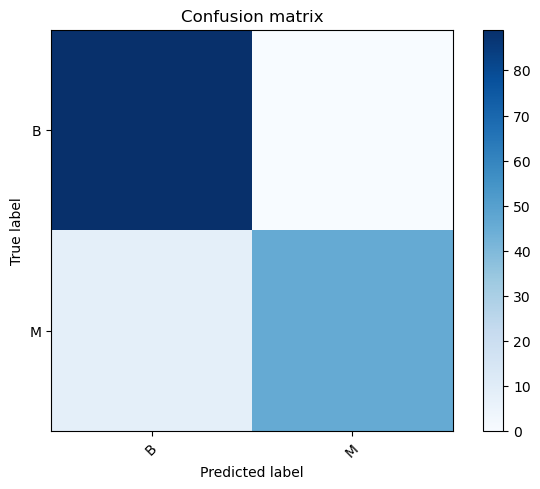

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        89
           1       1.00      0.85      0.92        54

    accuracy                           0.94       143
   macro avg       0.96      0.93      0.94       143
weighted avg       0.95      0.94      0.94       143



In [16]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, diagnosis)
plt.show()

print(classification_report(y_true, pred))

### ROC Curves

**An ROC curve measures how good a model is regardless of the cutoff.** 

The following code shows an ROC chart for the breast cancer neural network.  The area under the curve (AUC) is also an important measure.  The larger the AUC, the better.

5/5 [==============================] - 0s 1000us/step


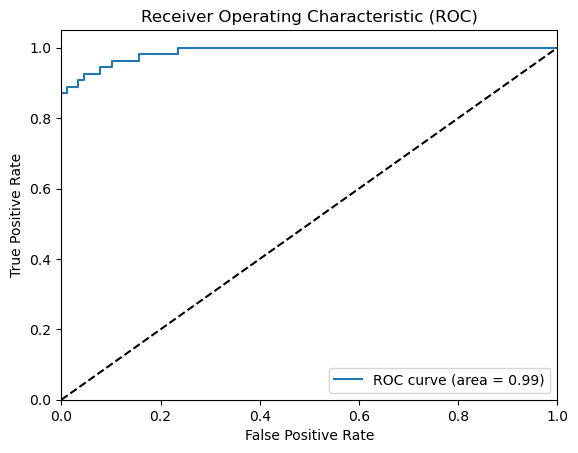

In [17]:
pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)

# Visualizing multi-class classification models

We've already seen multi-class classification, with the iris dataset.  Confusion matrixes work just fine with 3 classes.  The following code generates a confusion matrix for iris.

In [18]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

species = encode_text_index(df,"species")
x,y = to_xy(df,"species")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('dnn/best_weights.hdf5') # load weights from best model

Epoch 1/100
4/4 - 0s - loss: 1.3757 - val_loss: 1.4562 - 477ms/epoch - 119ms/step
Epoch 2/100
4/4 - 0s - loss: 1.2982 - val_loss: 1.3543 - 37ms/epoch - 9ms/step
Epoch 3/100
4/4 - 0s - loss: 1.2231 - val_loss: 1.2722 - 36ms/epoch - 9ms/step
Epoch 4/100
4/4 - 0s - loss: 1.1744 - val_loss: 1.2036 - 34ms/epoch - 8ms/step
Epoch 5/100
4/4 - 0s - loss: 1.1288 - val_loss: 1.1520 - 32ms/epoch - 8ms/step
Epoch 6/100
4/4 - 0s - loss: 1.0954 - val_loss: 1.1098 - 32ms/epoch - 8ms/step


c:\Users\cdub6\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 7/100
4/4 - 0s - loss: 1.0667 - val_loss: 1.0739 - 33ms/epoch - 8ms/step
Epoch 8/100
4/4 - 0s - loss: 1.0432 - val_loss: 1.0412 - 32ms/epoch - 8ms/step
Epoch 9/100
4/4 - 0s - loss: 1.0180 - val_loss: 1.0133 - 31ms/epoch - 8ms/step
Epoch 10/100
4/4 - 0s - loss: 0.9935 - val_loss: 0.9880 - 32ms/epoch - 8ms/step
Epoch 11/100
4/4 - 0s - loss: 0.9714 - val_loss: 0.9634 - 32ms/epoch - 8ms/step
Epoch 12/100
4/4 - 0s - loss: 0.9501 - val_loss: 0.9381 - 35ms/epoch - 9ms/step
Epoch 13/100
4/4 - 0s - loss: 0.9273 - val_loss: 0.9134 - 35ms/epoch - 9ms/step
Epoch 14/100
4/4 - 0s - loss: 0.9056 - val_loss: 0.8897 - 35ms/epoch - 9ms/step
Epoch 15/100
4/4 - 0s - loss: 0.8848 - val_loss: 0.8658 - 32ms/epoch - 8ms/step
Epoch 16/100
4/4 - 0s - loss: 0.8631 - val_loss: 0.8417 - 33ms/epoch - 8ms/step
Epoch 17/100
4/4 - 0s - loss: 0.8426 - val_loss: 0.8176 - 32ms/epoch - 8ms/step
Epoch 18/100
4/4 - 0s - loss: 0.8216 - val_loss: 0.7947 - 32ms/epoch - 8ms/step
Epoch 19/100
4/4 - 0s - loss: 0.8008 - val_

2/2 [==============================] - 0s 1ms/step
[[15  0  0]
 [ 0 11  0]
 [ 0  0 12]]
Ploting confusion matrix


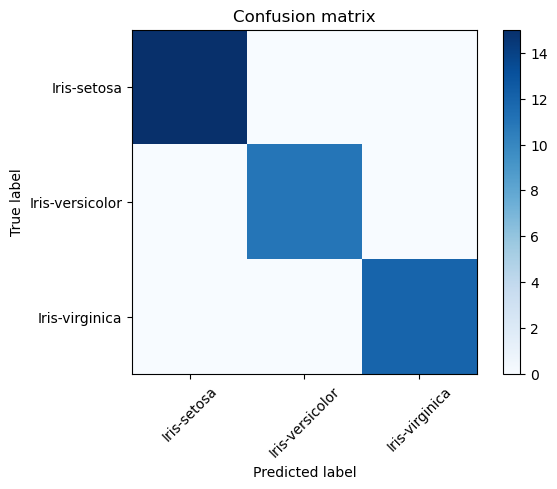

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [19]:
import numpy as np

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, species)
plt.show()


print(classification_report(y_true, pred))

# Visualizing regression models

We've already seen regression with the MPG dataset.  Regression uses its own set of visualizations, one of the most common is the lift chart.  The following code generates a lift chart.

Epoch 1/500
10/10 - 1s - loss: 2903.4792 - val_loss: 395.6825 - 516ms/epoch - 52ms/step
Epoch 2/500
10/10 - 0s - loss: 250.2036 - val_loss: 196.0124 - 38ms/epoch - 4ms/step
Epoch 3/500
10/10 - 0s - loss: 200.0826 - val_loss: 146.6717 - 36ms/epoch - 4ms/step
Epoch 4/500
10/10 - 0s - loss: 162.5552 - val_loss: 150.7139 - 30ms/epoch - 3ms/step
Epoch 5/500
10/10 - 0s - loss: 159.5386 - val_loss: 129.4798 - 40ms/epoch - 4ms/step
Epoch 6/500
10/10 - 0s - loss: 150.3623 - val_loss: 120.0376 - 38ms/epoch - 4ms/step


c:\Users\cdub6\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 7/500
10/10 - 0s - loss: 142.5791 - val_loss: 118.3726 - 39ms/epoch - 4ms/step
Epoch 8/500
10/10 - 0s - loss: 135.5707 - val_loss: 129.3783 - 27ms/epoch - 3ms/step
Epoch 9/500
10/10 - 0s - loss: 128.7512 - val_loss: 101.8196 - 37ms/epoch - 4ms/step
Epoch 10/500
10/10 - 0s - loss: 110.7894 - val_loss: 94.3261 - 35ms/epoch - 3ms/step
Epoch 11/500
10/10 - 0s - loss: 110.4564 - val_loss: 117.1170 - 26ms/epoch - 3ms/step
Epoch 12/500
10/10 - 0s - loss: 103.0375 - val_loss: 78.6188 - 35ms/epoch - 4ms/step
Epoch 13/500
10/10 - 0s - loss: 95.8731 - val_loss: 71.3420 - 38ms/epoch - 4ms/step
Epoch 14/500
10/10 - 0s - loss: 89.9201 - val_loss: 67.8267 - 37ms/epoch - 4ms/step
Epoch 15/500
10/10 - 0s - loss: 85.9777 - val_loss: 63.3135 - 37ms/epoch - 4ms/step
Epoch 16/500
10/10 - 0s - loss: 83.0029 - val_loss: 67.1516 - 27ms/epoch - 3ms/step
Epoch 17/500
10/10 - 0s - loss: 79.0651 - val_loss: 68.7442 - 27ms/epoch - 3ms/step
Epoch 18/500
10/10 - 0s - loss: 76.4304 - val_loss: 79.4267 - 26ms/ep

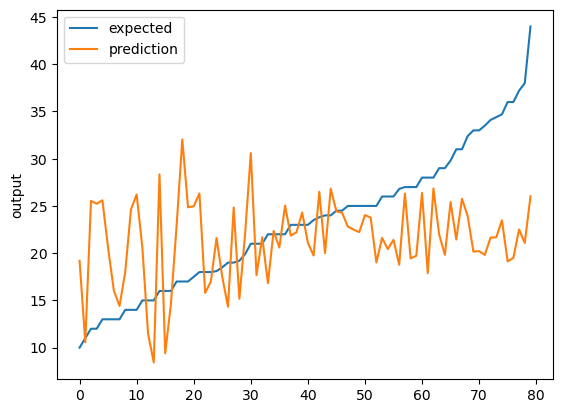

In [20]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


path = "./data/"
preprocess = False

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
encode_text_dummy(df, 'origin')
df.drop('name', axis=1,inplace=True)
if preprocess:
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')
    encode_numeric_zscore(df, 'year')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))      # try changing 100 to 10
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=500)

model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test, sort= True)

The lift chart as shown above was achieved by performing the following actions:

* Sort the data by expected output.  Plot the blue line above.  Blue line is always increasing. 
* For every point on the x-axis plot the predicted value for that same data point.  This is the orange line above.
* The x-axis is the index of test data after sorting.  The index always starts low and ends high.

Reading a lift chart:
* The expected and predict lines should be close.  Notice where one is above the other.
* The above chart is the most accurate on lower MPG.

#### Regression lift chart without sorting on expected output (y_test)

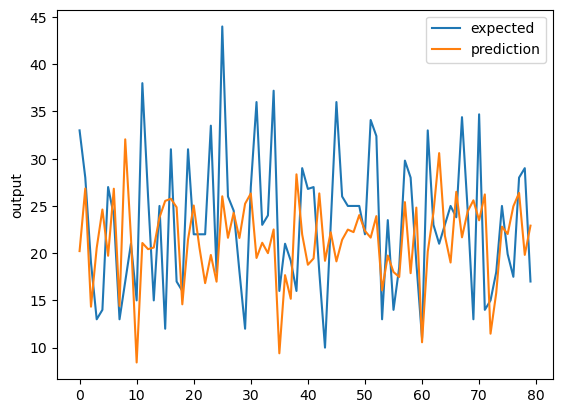

In [21]:
chart_regression(pred.flatten(),y_test,sort=False)

### References:

* [Google Colab](https://colab.research.google.com/) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow with free GPU support.  No setup needed.
* [IBM Cognitive Class Labs](https://www.datascientistworkbench.com) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow.  No setup needed.
* [Python Anaconda](https://www.continuum.io/downloads) - Python distribution that includes many data science packages, such as Numpy, Scipy, Scikit-Learn, Pandas, and much more.
* [TensorFlow](https://www.tensorflow.org/) - Google's mathematics package for deep learning.
* [Kaggle](https://www.kaggle.com/) - Competitive data science.  Good source of sample data.
* T81-558: Applications of Deep Neural Networks. Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/)